In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Input
from tensorflow.keras.optimizers import Adam


In [9]:
df = pd.read_csv(
    '/content/data1234.csv',
    encoding='latin1',
    on_bad_lines='skip',
    low_memory=False
)


In [10]:
df.columns
x = pd.to_numeric(df['no2'], errors='coerce').dropna().values
print(x)

[17.4  7.  28.5 ... 11.2 17.   6.7]


In [11]:
r = 102303950
mod7 = r % 7
mod5 = r % 5
a_r = 0.5 * mod7
b_r = 0.3 * (mod5 + 1)
print('a_r : ',a_r,' b_r : ',b_r)


a_r :  0.0  b_r :  0.3


In [12]:
z = x + a_r * np.sin(b_r * x)
print(z)

[17.4  7.  28.5 ... 11.2 17.   6.7]


In [13]:
z = (z - z.mean()) / z.std()
print(z)

[-0.18658981 -1.08511959  0.77241794 ... -0.72225179 -0.22114865
 -1.11103872]


In [14]:
# GAN parameter
latent_dim = 1
epochs = 3000
batch_size = 64
lr = 0.0002

generator = Sequential([
    Input(shape=(latent_dim,)),
    Dense(32),
    LeakyReLU(0.2),
    Dense(32),
    LeakyReLU(0.2),
    Dense(1)
])

discriminator = Sequential([
    Input(shape=(1,)),
    Dense(16),
    LeakyReLU(0.2),
    Dense(16),
    LeakyReLU(0.2),
    Dense(1, activation="sigmoid")
])

discriminator.trainable = True
discriminator.compile(
    loss="binary_crossentropy",
    optimizer=Adam(lr),
    metrics=["accuracy"]
)

In [15]:
discriminator.trainable = False

gan = Sequential([generator, discriminator])
gan.compile(loss="binary_crossentropy", optimizer=Adam(lr))

In [16]:
for epoch in range(epochs):

    # Train Discriminator
    discriminator.trainable = True

    idx = np.random.randint(0, z.shape[0], batch_size)
    real_samples = z[idx]

    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_samples = generator.predict(noise, verbose=0)

    d_loss_real = discriminator.train_on_batch(
        real_samples, np.ones((batch_size, 1))
    )
    d_loss_fake = discriminator.train_on_batch(
        fake_samples, np.zeros((batch_size, 1))
    )

    # Train Generator
    discriminator.trainable = False
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

    if epoch % 500 == 0:
        print(
            f"Epoch {epoch} | D loss: {0.5*(d_loss_real[0]+d_loss_fake[0]):.4f} | G loss: {g_loss:.4f}"
        )


Epoch 0 | D loss: 0.6618 | G loss: 0.6794
Epoch 500 | D loss: 0.6900 | G loss: 0.6921
Epoch 1000 | D loss: 0.6907 | G loss: 0.6907
Epoch 1500 | D loss: 0.6909 | G loss: 0.6910
Epoch 2000 | D loss: 0.6914 | G loss: 0.6904
Epoch 2500 | D loss: 0.6908 | G loss: 0.6921


In [18]:
noise = np.random.normal(0, 1, (10000, latent_dim))
z_fake = generator.predict(noise)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


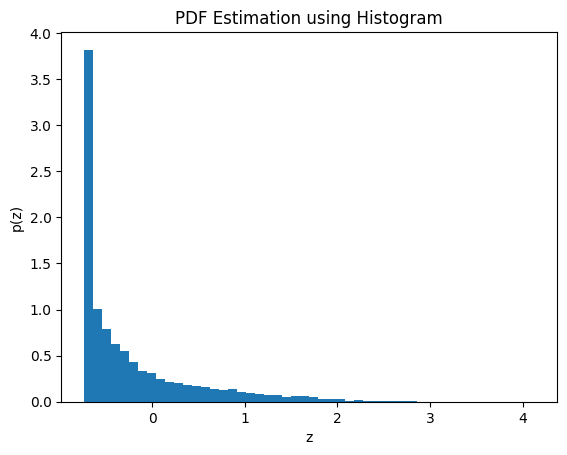

In [19]:
plt.figure()
plt.hist(z_fake, bins=50, density=True)
plt.title("PDF Estimation using Histogram")
plt.xlabel("z")
plt.ylabel("p(z)")
plt.show()

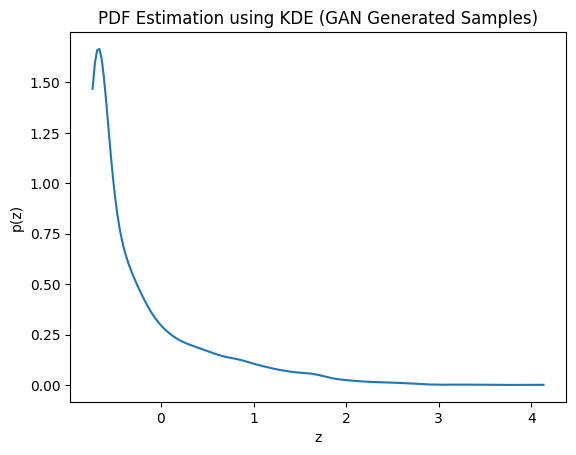

In [20]:
kde = gaussian_kde(z_fake.flatten())
z_vals = np.linspace(z_fake.min(), z_fake.max(), 200)
pdf_vals = kde(z_vals)

plt.figure()
plt.plot(z_vals, pdf_vals)
plt.title("PDF Estimation using KDE (GAN Generated Samples)")
plt.xlabel("z")
plt.ylabel("p(z)")
plt.show()

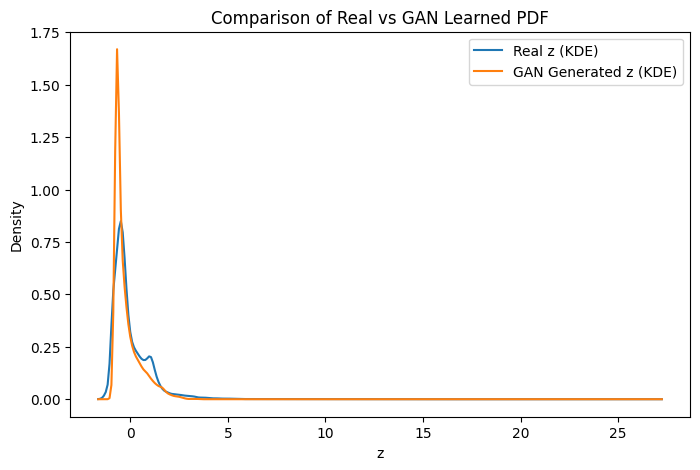

In [21]:
# KDE for real z
kde_real = gaussian_kde(z)
z_axis = np.linspace(min(z.min(), z_fake.min()),
                     max(z.max(), z_fake.max()), 300)

pdf_real = kde_real(z_axis)

# KDE for fake z
kde_fake = gaussian_kde(z_fake.flatten())
pdf_fake = kde_fake(z_axis)

plt.figure(figsize=(8,5))
plt.plot(z_axis, pdf_real, label="Real z (KDE)")
plt.plot(z_axis, pdf_fake, label="GAN Generated z (KDE)")
plt.xlabel("z")
plt.ylabel("Density")
plt.title("Comparison of Real vs GAN Learned PDF")
plt.legend()
plt.show()
